In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
filtered_dataset = pd.read_csv('../data/raw/filtered.tsv', sep='\t')
filtered_dataset.rename(columns={filtered_dataset.columns[0]: "id"}, inplace=True)
filtered_dataset.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


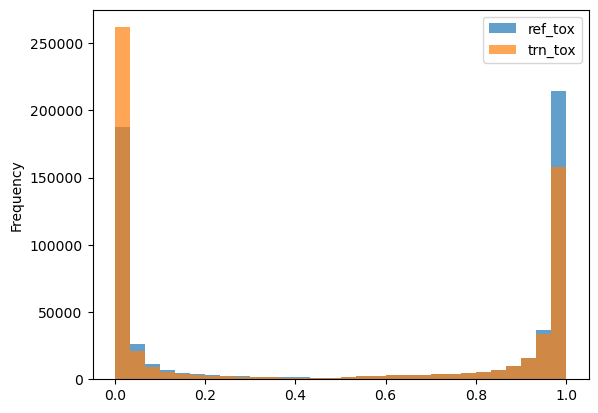

In [9]:
import matplotlib.pyplot as plt

toxicity = filtered_dataset[['ref_tox', 'trn_tox']]
ax = toxicity.plot.hist(bins=30, alpha=0.7)


In [4]:
sorted = filtered_dataset.sort_values(by=['ref_tox'], ascending=False)
sorted.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
551255,551255,His father would have used a booming voice to ...,his father would have answered with his thunde...,0.729428,0.091954,0.999724,0.004599
101676,101676,You have to send those idiots back in.,you have to get those guys back there.,0.622852,0.000000,0.999723,0.000115
258368,258368,Salina could be with that stupid cop.,Salina could be with the cop.,0.774944,0.210526,0.999723,0.000500
318050,318050,And don't let those idiots in radiology hold y...,don't let them fool you in radiology.,0.711188,0.283019,0.999723,0.000874
70934,70934,My idiot friend here brought marijuana... - on...,my friend here took a marijuana...,0.715508,0.396552,0.999722,0.000161


In [5]:
print(sorted['reference'].iloc[0])
print(sorted['translation'].iloc[0])

His father would have used a booming voice to wrench a reply from this stupid machine.
his father would have answered with his thunder voice from this blunt machine.


[]

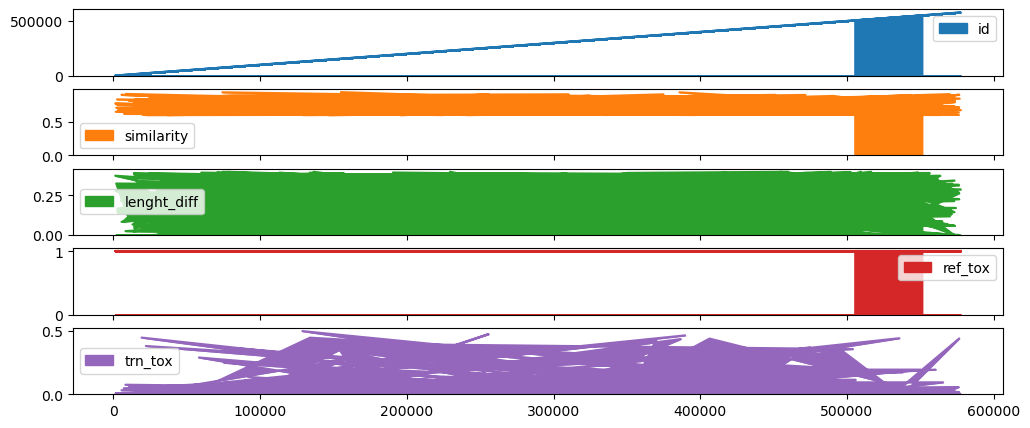

In [6]:
sorted.iloc[:1000].plot.area(figsize=(12, 5), subplots=True)
plt.plot()

Max ref_len: 1401
Max trn_let: 979


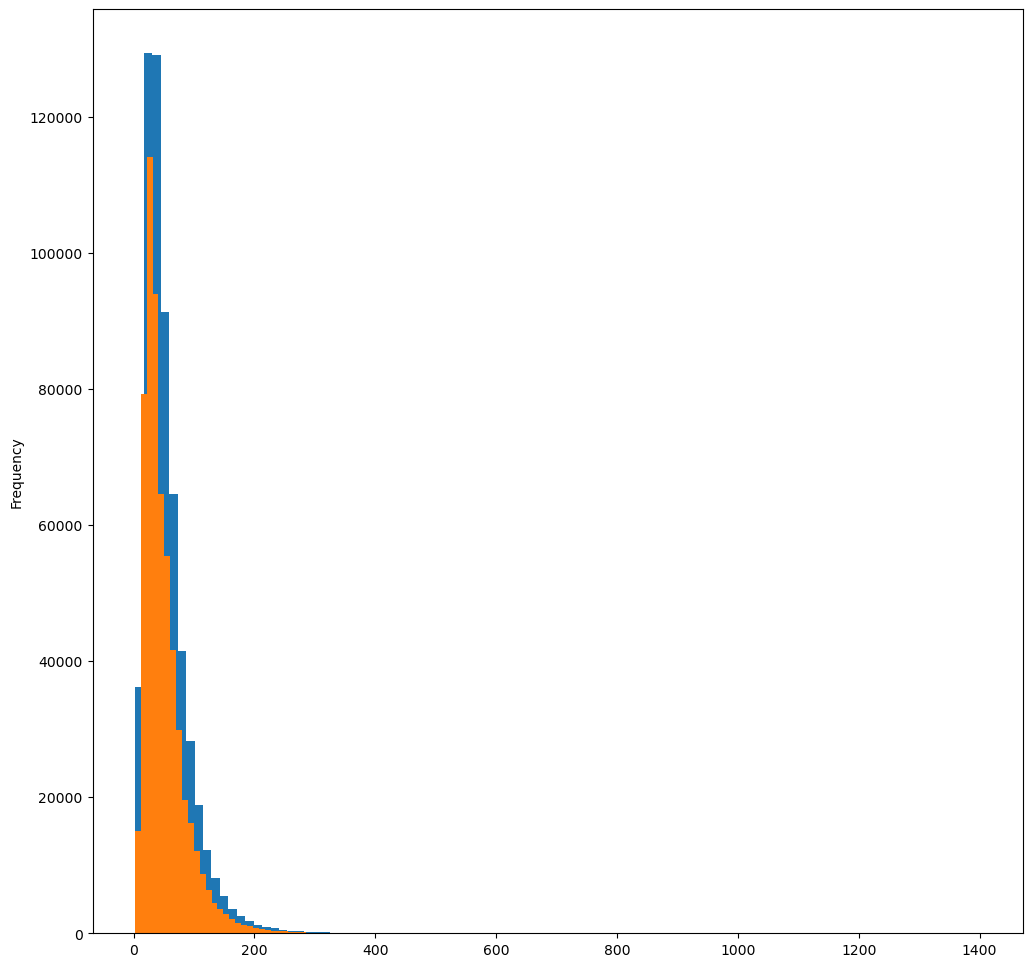

In [7]:
# Compute distribuition of reference and translation lengths
filtered_dataset['ref_len'] = filtered_dataset['reference'].str.len()
filtered_dataset['trn_len'] = filtered_dataset['translation'].str.len()

filtered_dataset['ref_len'].plot.hist(bins=100, figsize=(12, 12))
plt.plot()

filtered_dataset['trn_len'].plot.hist(bins=100, figsize=(12, 12))
plt.plot()

# Compute max length of reference and translation
print(f"Max ref_len: {filtered_dataset['ref_len'].max()}")
print(f"Max trn_let: {filtered_dataset['trn_len'].max()}")



# Text cleaning
For text cleaning, you can use lower casting, punctuation removal, numbers removal, tokenization, stop words removal, stemming. This will get a perfectly cleaned text without any garbage information.

In [8]:
import re


def lower_text(text: str):
    return text.lower()

def remove_punctuation(text: str):
    """
    Substitute all punctiations with space in case of
    "hello!nice to meet you"
    
    If subs with '' -> "hellonice to meet you"
    With ' ' -> "hello nice to meet you"
    """
    text_nopunct = re.sub(r'[^a-z|\s]+', ' ', text)
    return text_nopunct

def remove_multiple_spaces(text: str):
    text_no_doublespace = re.sub('\s+', ' ', text).strip()
    return text_no_doublespace

In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Use basic_english tokenizer from torchtext to split sentence strings into tokens
tokenizer = get_tokenizer('basic_english')

# Yields each token from an iterable of (sentence) strings
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(sorted['reference']))
vocab.set_default_index(0)
print(len(vocab))

c:\Users\maxim\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


107362


In [10]:
sample = sorted['reference'][0]
print(sample)
tokenized = tokenizer(sample)
print(tokenized)
encoded = vocab(tokenized)
print(encoded)

If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.
['if', 'alkar', 'is', 'flooding', 'her', 'with', 'psychic', 'waste', ',', 'that', 'explains', 'the', 'high', 'level', 'of', 'neurotransmitters', '.']
[31, 40622, 20, 23340, 46, 23, 2977, 695, 1, 13, 5925, 4, 563, 1957, 10, 31018, 0]


In [11]:
def preprocessing_stage(text: str) -> list:
    _lowered = lower_text(text)
    _single_spaced = remove_multiple_spaces(_lowered)
    _tokenized = tokenizer(_single_spaced)

    return list(_tokenized)

In [12]:
from torch.utils.data import Dataset
import torch


class ToxicDataset(Dataset):
    def __init__(self, dataframe, vocab):
        self.dataframe = dataframe
        self.vocab = vocab

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ref = self.dataframe.iloc[idx, 1]
        trn = self.dataframe.iloc[idx, 2]

        return ref, trn

In [13]:
from transformers import (
    EncoderDecoderModel,
    AutoTokenizer,
    BertTokenizer,
    BertGenerationEncoder,
    BertGenerationDecoder,
    BertGenerationConfig,
)
from transformers import BertTokenizerFast


# bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained(
#     "bert-base-uncased", "bert-base-uncased"
# )

# # Set tokenizer
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
# tokenizer.bos_token = tokenizer.cls_token
# tokenizer.eos_token = tokenizer.sep_token

# # Set model's config
# bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
# bert2bert.config.eos_token_id = tokenizer.eos_token_id
# bert2bert.config.pad_token_id = tokenizer.pad_token_id

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import datasets

batch_size = 1

dataset = ToxicDataset(sorted, vocab)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

def gen_train():
    for idx in range(len(train_dataset)):
        # yield torch_dataset[idx]  # this has to be a dictionary
        yield {
            "reference": train_dataset[idx][0],
            "translation": train_dataset[idx][1],
        }

def gen_test():
    for idx in range(len(test_dataset)):
        # yield torch_dataset[idx]  # this has to be a dictionary
        yield {
            "reference": test_dataset[idx][0],
            "translation": test_dataset[idx][1],
        }

# Convert from PyTorch dataset to HuggingFace dataset
train_dataset = datasets.Dataset.from_generator(gen_train)
test_dataset = datasets.Dataset.from_generator(gen_test)


# train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
# train_dataset_len = len(train_dataset)

Generating train split: 462221 examples [00:32, 14171.92 examples/s]
Generating train split: 115556 examples [00:08, 14198.03 examples/s]


In [15]:
# train_dataset = train_dataset
# %pip install rouge_score

In [17]:
import nlp
import logging
from transformers import BertTokenizer, GPT2Tokenizer, EncoderDecoderModel, Trainer, TrainingArguments

logging.basicConfig(level=logging.INFO)

model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-cased", "gpt2")
# cache is currently not supported by EncoderDecoder framework
model.decoder.config.use_cache = False
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# CLS token will work as BOS token
bert_tokenizer.bos_token = bert_tokenizer.cls_token

# SEP token will work as EOS token
bert_tokenizer.eos_token = bert_tokenizer.sep_token


# make sure GPT2 appends EOS in begin and end
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs


GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# set pad_token_id to unk_token_id -> be careful here as unk_token_id == eos_token_id == bos_token_id
gpt2_tokenizer.pad_token = gpt2_tokenizer.unk_token


# set decoding params
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id
model.config.eos_token_id = gpt2_tokenizer.eos_token_id
model.config.max_length = 142
model.config.min_length = 56
model.config.no_repeat_ngram_size = 3
model.early_stopping = True
model.length_penalty = 2.0
model.num_beams = 4

# load train and validation data
# train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
# val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation[:5%]")

# load rouge for validation
rouge = nlp.load_metric("rouge", experiment_id=1)

encoder_length = 256
decoder_length = 256
batch_size = 16


# map data correctly
def map_to_encoder_decoder_inputs(batch):    # Tokenizer will automatically set [BOS] <text> [EOS] 
    # use bert tokenizer here for encoder
    inputs = bert_tokenizer(batch["reference"], padding="max_length", truncation=True, max_length=encoder_length)
    # force summarization <= 128
    outputs = gpt2_tokenizer(batch["translation"], padding="max_length", truncation=True, max_length=decoder_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["labels"] = outputs.input_ids.copy()
    batch["decoder_attention_mask"] = outputs.attention_mask

    # complicated list comprehension here because pad_token_id alone is not good enough to know whether label should be excluded or not
    batch["labels"] = [
        [-100 if mask == 0 else token for mask, token in mask_and_tokens] for mask_and_tokens in [zip(masks, labels) for masks, labels in zip(batch["decoder_attention_mask"], batch["labels"])]
    ]

    assert all([len(x) == encoder_length for x in inputs.input_ids])
    assert all([len(x) == decoder_length for x in outputs.input_ids])

    return batch


def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = gpt2_tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = gpt2_tokenizer.eos_token_id
    label_str = gpt2_tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


# make train dataset ready
train_dataset = train_dataset.map(
    map_to_encoder_decoder_inputs, batched=True, batch_size=batch_size, remove_columns=["reference", "translation"],
)
train_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

# same for validation dataset
# TODO: rename test_dataset to val_dataset
val_dataset = test_dataset.map(
    map_to_encoder_decoder_inputs, batched=True, batch_size=batch_size, remove_columns=["reference", "translation"],
)
val_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.ln_cross_attn.bias', 'h.10.crossattention.q_attn.bias', 'h.4.ln_cross_attn.bias', 'h.1.crossattention.c_proj.bias', 'h.3.crossattention.q_attn.weight', 'h.3.ln_cross_attn.weight', 'h.5.crossattention.c_attn.bias', 'h.5.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.0.crossattention.q_attn.weight', 'h.6.crossattention.q_attn.bias', 'h.7.ln_cross_attn.bias', 'h.1.crossattention.q_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.0.crossattention.c_attn.bias', 'h.8.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.3.crossattention.c_proj.bias', 'h.8.ln_cross_attn.bias', 'h.10.crossattention.c_attn.bias', 'h.10.ln_cross_attn.bias', 'h.6.crossattention.c_attn.bias', 'h.2.ln_cross_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.3.ln_cross_attn.bias', 'h.2.crossattention.c_proj.weight', 'h.3.crossattention.c_attn.bias', 'h.10.l

In [19]:

# set training arguments - these params are not really tuned, feel free to change
training_args = TrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # predict_from_generate=True,
    # evaluate_during_training=True,
    do_train=True,
    do_eval=True,
    logging_steps=1000,
    save_steps=1000,
    eval_steps=1000,
    overwrite_output_dir=True,
    warmup_steps=2000,
    save_total_limit=10,
    fp16=True,
)

# instantiate trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# start training
trainer.train()

  0%|          | 0/86667 [00:00<?, ?it/s]c:\Users\maxim\anaconda3\envs\torch\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:642: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
  0%|          | 10/86667 [02:02<290:07:17, 12.05s/it]

KeyboardInterrupt: 

In [ ]:
# def eval(s: str) -> str:
#     bert2bert.eval()
#     input_ids = tokenizer(
#         s, add_special_tokens=False, return_tensors="pt"
#     ).input_ids
#     input_ids = input_ids.to('cuda')
#     output = bert2bert.generate(input_ids)
#     output = output.to('cpu')
#     print(tokenizer.decode(output[0]))


def generate_summary(s):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = bert_tokenizer([s], padding="max_length", truncation=True, max_length=encoder_length, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = gpt2_tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # batch["pred"] = output_str

    return output_str

In [ ]:
result = generate_summary("Fuck! Get out of the fucking way!")
print(result)

In [ ]:
# %pip install accelerate -U